In [13]:
import os
import pydicom
import pandas as pd

In [14]:
%matplotlib inline
import pylab

## Get categories

In [15]:
train_csv_path = "dataset/stage_1_train.csv"
train_data = pd.read_csv(train_csv_path)

In [16]:
def getImageName(_id):
    return _id.replace("_any","")+".dcm"

In [17]:
hem = []
nohem = []
THRESHOLD = 0.25

In [18]:
for _id, label in train_data.values:
    if 'any' in _id:
        if label > THRESHOLD:
            hem.append(getImageName(_id))
        else:
            nohem.append(getImageName(_id))

In [19]:
[len(hem), len(nohem)]

[97103, 577159]

<BarContainer object of 2 artists>

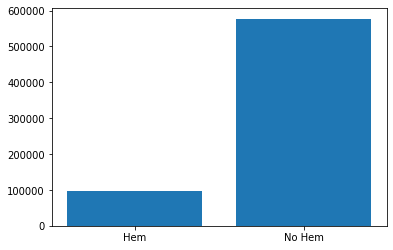

In [22]:
pylab.bar(['Hem', 'No Hem'], [len(hem), len(nohem)])

## Analyze

### Setup

In [11]:
import numpy as np

In [12]:
dirpath="dataset/stage_1_train_images"

In [20]:
file_path = os.path.join(dirpath, hem[0])
dc = pydicom.dcmread(file_path)

In [21]:
def getImg(dc):
    '''Scale pixel data to Hounsfield units with a linear transformation'''
    intercept = dc[('0028','1052')].value
    slope = dc[('0028','1053')].value
    return dc.pixel_array * slope + intercept    

In [42]:
from PIL import Image, ImageEnhance

In [61]:
max(np.asarray(cleanDC(dc)).flatten())

255.0

In [72]:
pil_img = Image.fromarray(cleanDC(dc), mode="RGB")
sum(np.asarray(pil_img).flatten())
# pil_img

29105

In [101]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)

In [106]:
min(np.asarray(change_contrast(pil_img, 100)).flatten())

0

In [93]:
sum(np.asarray(change_contrast(pil_img, 100)).flatten())

25092

In [123]:
def cleanDC(dc, clip_range = (13,75)):
    # Linear transorm image to HU units
    img = getImg(dc)
    
    # Clamp pixel values to only HU range we want
    clipped = np.clip(img, clip_range[0], clip_range[1])
    
    # Normlaize pixels from 0-1
    norm = (clipped - min(clipped.flatten())) / (max(clipped.flatten())-min(clipped.flatten()))
    
    # Scale values from 0-255 for CNN's
    rgb_scaled = 255 * norm
    
    pil_img = Image.fromarray(rgb_scaled, mode="L")
    contrasted = np.asarray(change_contrast(pil_img, 10))
    
    return (contrasted - min(contrasted.flatten())) / (max(contrasted.flatten())-min(contrasted.flatten()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


0.0

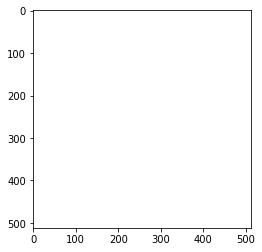

In [124]:
pylab.imshow(cleanDC(dc, (13,75)), cmap="bone")
getRatio(cleanDC(dc, (13,75)), 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


0.0

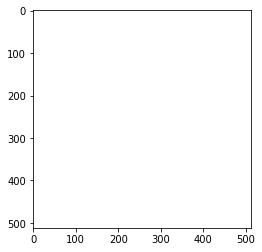

In [117]:
pylab.imshow(cleanDC(dc, (13, 100)), cmap="bone")
getRatio(cleanDC(dc, (13,100)), 0.1)

### Iterate

In [13]:
files_to_analyze_each = 1000
hem_imgs = []
nohem_imgs = []
for i in range(files_to_analyze_each):
    
    if i == files_to_analyze_each/4:
        print('1/4 done!')
        
    if i == files_to_analyze_each/2:
        print('Half done!')
    
    if i == 3*files_to_analyze_each/4:
        print('3/4 done!')
    
    #hem
    try:
        file_path = os.path.join(dirpath, hem[i])
        hem_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)))
    except:
        pass
#         file_path = os.path.join(dirpath, hem[len(hem)-1-i])
#         hem_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)) )              
    
    #no hem
    try:
        file_path = os.path.join(dirpath, nohem[i])
        nohem_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)))
    except:
        pass
#         file_path = os.path.join(dirpath, nohem[len(hem)-1-i])
#         nohem_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)) )  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


1/4 done!
Half done!
3/4 done!


In [15]:
nohem_imgs = nohem_imgs[:-1]

In [16]:
len(hem_imgs), len(nohem_imgs)

(999, 999)

In [75]:
def getRatio(img, threshold):
    
    ''' Over threhsold / under threshold '''
    
    over_threshold = len(np.where(img > threshold)[0])
    return over_threshold / (len(img.flatten()) - over_threshold)    

def getCount(img, threshold):
    
    ''' Over threhsold,  under threshold '''
    
    over_threshold = len(np.where(img > threshold)[0])
    return over_threshold

def average(_list):
    return sum(_list) / len(_list)

In [18]:
def plotRatios(hem_imgs, nohem_imgs, threshold):
    hem_ratios = []
    no_hem_ratios = []

    for _hem, _nohem in zip(hem_imgs, nohem_imgs):
        hem_ratios.append(getRatio(_hem, threshold))
        no_hem_ratios.append(getRatio(_nohem, threshold))  
        
#         hem_ratios.append(getCount(_hem, threshold))
#         no_hem_ratios.append(getCount(_nohem, threshold))  

    print("Using threhsold of ", threshold)
    print('Hem ratio', average(hem_ratios), 'Non hem ratio', average(no_hem_ratios))
    pylab.bar(["Hem", "No hem"], [average(hem_ratios), average(no_hem_ratios)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Using threhsold of  0.1
Hem ratio 0.40650796666213573 Non hem ratio 0.3173628877008454


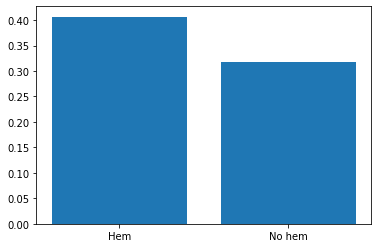

In [19]:
# 13-100
plotRatios(hem_imgs, nohem_imgs, 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Using threhsold of  0.5
Hem ratio 0.11188619418641285 Non hem ratio 0.11987294995731303


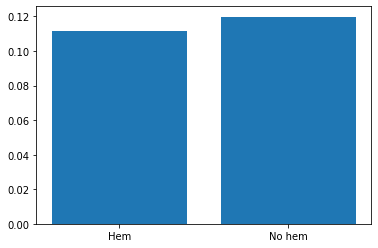

In [20]:
plotRatios(hem_imgs, nohem_imgs, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Using threhsold of  0.75
Hem ratio 0.09623975984035682 Non hem ratio 0.10534346781953931


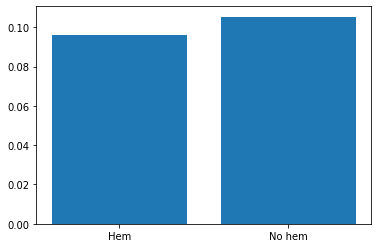

In [21]:
plotRatios(hem_imgs, nohem_imgs, 0.75)

## Train

In [22]:
def predictHem(img, hem_ratio = 0.40650796666213573, no_hem_ratio = 0.3173628877008454, pixel_threshold=0.1):
    ratio_threshold = average([hem_ratio, no_hem_ratio])
    ratio = getRatio(img, pixel_threshold)
    
    if ratio > ratio_threshold:
        return 1 # hem
    else:
        return 0 # no hem

In [23]:
def accuracy(trueval, testval):
    
    if trueval == 0:
        return 100 * abs(trueval-testval)
    
    return 100 * abs(trueval-testval) / trueval

In [33]:
files_to_analyze_each = 100
test_imgs = []
test_labels = []
for i in range(1, files_to_analyze_each+1):
    
    #hem
    try:
        file_path = os.path.join(dirpath, hem[-i])
        test_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)))
        test_labels.append(1)
    except:
        pass
         
    
    #no hem
    try:
        file_path = os.path.join(dirpath, nohem[-i])
        test_imgs.append(cleanDC(pydicom.dcmread(file_path), (13,100)))
        test_labels.append(0)
    except:
        pass

In [38]:
len(test_imgs)

200

In [40]:
accuracies = []
for label, img in zip(test_labels, test_imgs):
    prediction = predictHem(img)
    accuracies.append(accuracy(label, prediction))

In [46]:
accuracies = np.array(accuracies)
len(np.where(accuracies > 0)[0])/len(test_imgs)

0.365

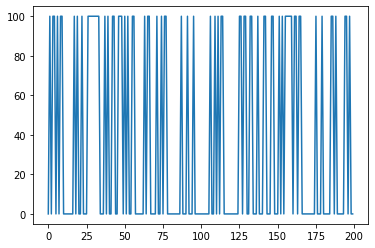

In [42]:
pylab.plot(accuracies)